# SacFC - PROD Retention Score
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 6, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
lkupclientid = 31 # SACFC
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(12155, 53)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12155 entries, 0 to 12154
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            12155 non-null  int64  
 1   dimCustomerMasterId     12155 non-null  int64  
 2   year                    12155 non-null  int64  
 3   productGrouping         12155 non-null  object 
 4   totalSpent              12155 non-null  float64
 5   recentDate              12155 non-null  object 
 6   attendancePercent       12155 non-null  float64
 7   renewedBeforeDays       12155 non-null  int64  
 8   isBuyer                 12155 non-null  object 
 9   source_tenure           12155 non-null  int64  
 10  tenure                  12155 non-null  int64  
 11  distToVenue             0 non-null      object 
 12  totalGames              12155 non-null  int64  
 13  recency                 12155 non-null  int64  
 14  missed_games_1          12155 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "attendancePercent",
            "clickToOpenRatio", 
            "clickToSendRatio", 
            "distToVenue",
            "inperson_contact", 
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "openToSendRatio",
            "phonecall",
            "recency",
            "source_tenure",
            "totalSpent",
            "recentDate",
            "isNextYear_Buyer",
            "productGrouping",
            "year"
]


# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (8848, 18)
Unseen Data For Predictions: (1561, 18)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
        "clickToOpenRatio", 
            "clickToSendRatio", 
            "distToVenue",
            "inperson_contact", 
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "openToSendRatio",
            "phonecall",
            "recency",
            "source_tenure",
            "totalSpent"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8015,0.8099,0.9256,0.8288,0.8745,0.4063,0.4216,0.3030


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8072,0.7987,0.9324,0.8304,0.8785,0.4197,0.4366
1,0.7952,0.8141,0.9164,0.8280,0.8699,0.3944,0.4059
2,0.8032,0.7841,0.9413,0.8214,0.8773,0.3920,0.4163
3,0.7965,0.7968,0.9021,0.8380,0.8689,0.4176,0.4233
4,0.8085,0.8212,0.9253,0.8360,0.8784,0.4338,0.4464
5,0.7979,0.8119,0.9324,0.8213,0.8733,0.3831,0.4027
6,0.8138,0.8256,0.9306,0.8381,0.8820,0.4473,0.4614
7,0.8045,0.8182,0.9324,0.8278,0.8770,0.4093,0.4271
8,0.7979,0.8266,0.9110,0.8339,0.8707,0.4115,0.4201
9,0.7899,0.8016,0.9323,0.8134,0.8688,0.3541,0.3759


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(1746, 53)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,source_tenure,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
10409,31,457923739,2022,Full Season,650.0,1970-01-01,0.000000,193,TRUE,1825,...,0,0,0.0,0,22,0,0,1,0.4562,0.5438
10410,31,457923783,2022,Full Season,1730.0,2022-06-18,0.571429,193,TRUE,2920,...,0,0,0.0,0,22,0,0,1,0.1862,0.8138
10411,31,457923849,2022,Full Season,1270.0,1970-01-01,0.000000,193,TRUE,2920,...,0,0,0.0,0,22,0,0,0,0.6418,0.3582
10412,31,457926158,2022,Full Season,288.0,2022-05-04,0.571429,193,TRUE,1825,...,0,0,0.0,0,22,0,0,0,0.7982,0.2018
10413,31,457926177,2022,Full Season,325.0,2022-06-18,0.714286,193,TRUE,2920,...,0,0,0.0,0,22,0,0,1,0.2370,0.7630


In [11]:
new_predictions["Label"].value_counts()

1    962
0    784
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.4, 0.6]       499
(0.6, 0.8]       478
(0.2, 0.4]       375
(0.8, 1.0]       239
(-0.001, 0.2]    155
Name: Score_1, dtype: int64

In [13]:
new_predictions["Score_1"].value_counts(bins=[0, 0.05, 0.1, 0.15, 0.8, 1.0])

(0.15, 0.8]       1435
(0.8, 1.0]         239
(0.1, 0.15]         41
(0.05, 0.1]         25
(-0.001, 0.05]       6
Name: Score_1, dtype: int64

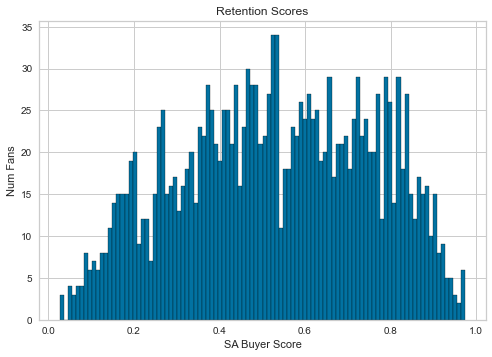

In [14]:
plt.hist(new_predictions["Score_1"], bins=100, edgecolor='black')
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.show()

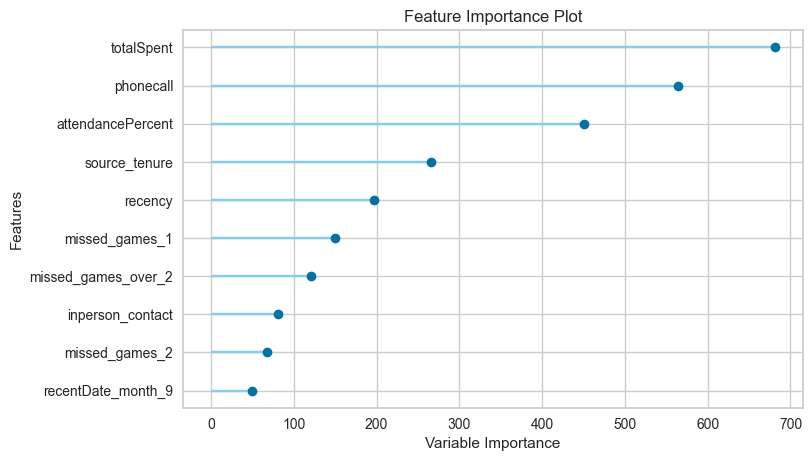

In [15]:
plot_model(best_model, plot='feature')

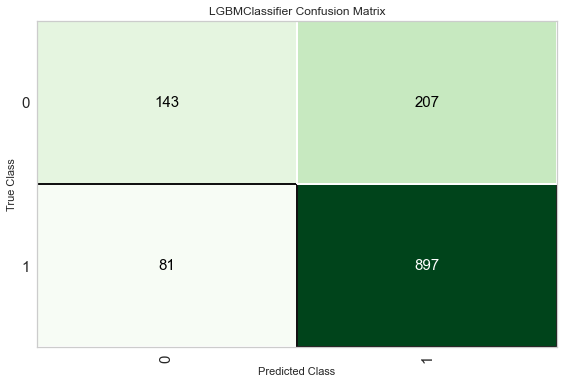

In [16]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above